In [21]:
import keras
from keras import losses
from keras import metrics
import keras.backend as K
from keras import initializers
from keras import regularizers
import numpy as np
from keras.datasets import mnist
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation, Lambda  
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D 

import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer

# PART 3 - VECTOR MATHS

Now that you've got your hands on with how a network is put together and trained, you're going to use a different type of model to explore the concept of 'Vector Math', one that we've seen in class.

Below is a model that's been taken from https://github.com/axium/VAE-SVHN
Feel free to compare code and convince youself it's the very same thing. 

We picked this model since it's been trained on a portion of a more interesting dataset, SVHN. http://ufldl.stanford.edu/housenumbers/

This model is a Variational Autoencoder, very similar to one you had some experience with in the previous assignment. While the prime focus on this assignment is GANs, we're actually looking at __generative networks__ as a whole and how some concepts __remain the same__ across different network styles and types.

Normally, the "Generator" part of a GAN is the component that generates a new data sample, using random noise. In this case, we're going to be using the decoder part of the VAE for the same purpose, both these components classify as __generative models__.

Remmember that an __encoder__ was used in an auto-encoder to __compress__ data into a smaller latent dimension and that the __decoder__ was used to take this downsampled data and __generate the original data__ from it. 

We can, similarly, provide arrays of random numbers to this decoder and have it generate "fake samples" for us, similar to a GANs generator. This is what we want you to do to explore vector maths.

While you should loosely be able to figure out what's happening in this model structure, understanding it completely is __not a pre-requiste for this part of the assignment__. Essentially, the questions given below can be answered __without detailed__ knowledge of the model. 

In [22]:
dim_representation = 100 # Dimension of Latent Representation

b_f = 128
# ENCODER
input_vae = Input(shape=(32,32,3))

encoder_hidden1 = Conv2D(filters = b_f, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(input_vae)
encoder_hidden1 = BatchNormalization()(encoder_hidden1)
encoder_hidden1 = Activation('relu')(encoder_hidden1)

encoder_hidden2 = Conv2D(filters = b_f*2, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(encoder_hidden1)
encoder_hidden2 = BatchNormalization()(encoder_hidden2)
encoder_hidden2 = Activation('relu')(encoder_hidden2)

encoder_hidden3 = Conv2D(filters = b_f*4, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(encoder_hidden2)
encoder_hidden3 = BatchNormalization()(encoder_hidden3)
encoder_hidden3 = Activation('relu')(encoder_hidden3)

encoder_hidden4 = Flatten()(encoder_hidden3)

# Latent Represenatation Distribution, P(z)
z_mean = Dense(dim_representation, activation='linear', 
                          kernel_initializer= initializers.he_normal(seed=None))(encoder_hidden4)
z_std_sq_log = Dense(dim_representation, activation='linear', 
                          kernel_initializer= initializers.he_normal(seed=None))(encoder_hidden4)

# Sampling z from P(z)
def sample_z(args):
    mu, std_sq_log = args
    epsilon = K.random_normal(shape=(K.shape(mu)[0], dim_representation), mean=0., stddev=1.)
    z = mu + epsilon * K.sqrt( K.exp(std_sq_log)) 
    return z

z = Lambda(sample_z)([z_mean, z_std_sq_log])


# DECODER
decoder_hidden0 = Dense(K.int_shape(encoder_hidden4)[1], activation='relu', kernel_initializer= initializers.he_normal(seed=None))(z)
decoder_hidden0 = Reshape(K.int_shape(encoder_hidden3)[1:])(decoder_hidden0)

decoder_hidden1 = Conv2DTranspose(filters = b_f*4, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(decoder_hidden0)
decoder_hidden1 = BatchNormalization()(decoder_hidden1)
decoder_hidden1 = Activation('relu')(decoder_hidden1)

decoder_hidden2 = Conv2DTranspose(filters = b_f*2, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(decoder_hidden1)
decoder_hidden2 = BatchNormalization()(decoder_hidden2)
decoder_hidden2 = Activation('relu')(decoder_hidden2)

decoder_hidden3 = Conv2DTranspose(filters = b_f, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(decoder_hidden2)
decoder_hidden3 = BatchNormalization()(decoder_hidden3)
decoder_hidden3 = Activation('relu')(decoder_hidden3)

decoder_hidden4 = Conv2D(filters = 3, kernel_size= 1, strides = (1,1), padding='valid', kernel_initializer = 'he_normal')(decoder_hidden3)
decoder_hidden4 = Activation('sigmoid')(decoder_hidden4)

In [23]:
# MODEL, both things put together
VAE = Model(input_vae, decoder_hidden4)

In [24]:
# Independantly usable smaller models

# Encoder Model
Encoder = Model(inputs = input_vae, outputs = [z_mean, z_std_sq_log])
no_of_encoder_layers = len(Encoder.layers)
no_of_vae_layers = len(VAE.layers)

# Decoder Model
decoder_input = Input(shape=(dim_representation,))
decoder_hidden = VAE.layers[no_of_encoder_layers+1](decoder_input)

for i in np.arange(no_of_encoder_layers+2 , no_of_vae_layers-1):
    decoder_hidden = VAE.layers[i](decoder_hidden)
decoder_hidden = VAE.layers[no_of_vae_layers-1](decoder_hidden)
Decoder = Model(decoder_input,decoder_hidden )

Lets look at our decoder now

In [25]:
Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8192)              827392    
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 8, 8, 512)         1049088   
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 512)         2048      
_________________________________________________________________
activation_25 (Activation)   (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 16, 16, 256)       524544    
__________

__QUESTION__ - Explain the values in the input and output dimensions of the Decoder here.

__ANSWER__ - Input could be 2d-np array(noise) of aX b where b should be 100. And it should output batch of 3-D images 

In [26]:
# DOWNLOAD THE WEIGHTS FROM THE GIVEN GITHUB REPO ABOVE:
# (click on the weights file and then click on the download button)

VAE.load_weights('vae_weights.h5')

__QUESTION__ - Why are we loading weights into the whole model at once and not just the decoder as we don't need the encoder?

__ANSWER__ - Maybe because weights given are for whole model. Other wise i don't think we need encoder part here.

Great, we have our decoder ready to generate fake data, we're going to explore the entire 100 dimensional space over which it can model fake data for us. Go to the GitHub repo and try and figure out how you'd like to give it the random noise to generate data samples with.

__For the task that require you to print images, go over the example repository linked above and try to figure out how to use MatPlotLib to print images in a grid fashion so they're easy to compare and check__

### TASK 1

Generate two rows of 10 images (much like on the REPO) using random noise as the seed for the decoder. 

### TASK 2

Now generate two data points and interpolate between them, have 8 interpolations so that you can have have 10 100d vectors in total.

NOTE - Sometimes you might get less visually impressive randomly generated images, it would be good then to repeat the generation process a few times to get nice starting images to work with. (This point is valid for all further parts)

Now run all of these 10 vectors through your model and so generate a total of 10 images. Print these out in one row so we can see the gradual change between the end points. 

(10, 100)


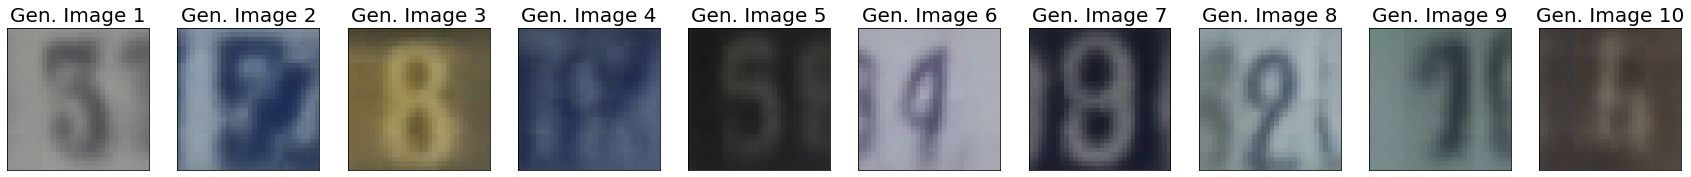

In [58]:
n = 10
eps = np.random.normal(0, 1, size=(n, dim_representation))
decoded_imgs = Decoder.predict(eps)
print(eps.shape)
  # how many digits we will display
plt.figure(figsize=(30,10))
for i in range(n):
    
    # Generated Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title('Gen. Image '+ str(i+1), size=20)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# plt.savefig('Generated.png')
# plt.close()
plt.show()

In [75]:
p1=eps.tolist()[0]    #Takes 1st and second images from above
p2=eps.tolist()[1]    
print(len(p2))


100


In [62]:
from scipy.interpolate import interp1d
linear_inter=interp1d([1,10],np.vstack([p1,p2]),axis=0)

array_inter=[]
for x in range(1,10):
    array_inter.append(linear_inter(x))

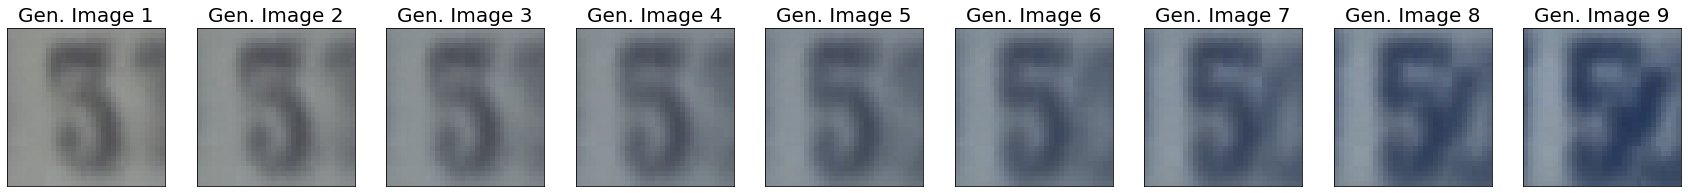

In [74]:
n=9
decoded_images= Decoder.predict(np.array(array_inter))
plt.figure(figsize=(30,10))
for i in range(n):
    
    # Generated Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i])
    plt.title('Gen. Image '+ str(i+1), size=20)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# plt.savefig('Generated.png')
# plt.close()
plt.show()

__QUESTION__ - What do you think is happening here, as we go from one type of image to another. What kind of data is the model getting from the interpolated points?

__ANSWER__ -  I can see the smooth transformation from first image to the second

(There is no right or wrong answer, this is only to gauge your understanding and to encourage you to think a bit, copying this off someone else won't make an iota of difference to your marks)

### TASK 3

By this point you've some idea of what vector maths is, the fact that different parts of the vector given to you represent different features of the final image. Our 100d vector thus, has different parts encode for different parts of the final image. It's time to drive this point home. 

Generate another two random data points, and interpolate between them. This time however, have 50 interpolated points and save the images in a folder. You will have to submit these images with your assignment. 

Once you're done, go to the first saved image and quickly go forward through to the last and you'll see much slower change.

(Look up functions that will allow you to save arrays as images)

Include your images in a zip with your submission notebook. Name your images sensibly. 

In [80]:
from scipy.interpolate import interp1d
linear_inter=interp1d([1,50],np.vstack([p1,p2]),axis=0)

array_inter=[]
for x in range(1,50):
    array_inter.append(linear_inter(x))

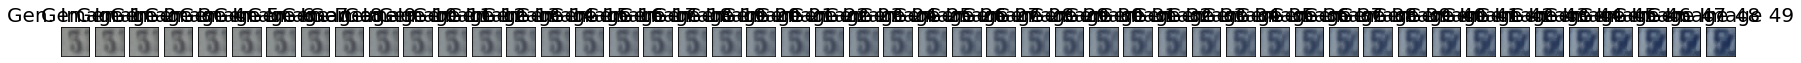

In [82]:
n=49
decoded_images= Decoder.predict(np.array(array_inter))
plt.figure(figsize=(30,10))
for i in range(n):
    
    # Generated Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i])
    plt.title('Gen. Image '+ str(i+1), size=20)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.savefig('Generated.png')
# plt.close()
plt.show()

Try to run your code a couple of times maybe till you get good starting and end points and then explain below what kind of changes you see happening gradually?

* What are the numbers changing into?
* What are the colors changing into?

__ANSWER__ -  Number is changing from 3 to 5. Similarly colour changes into from greenish to dark blue

### Task 4

Now generate 3 sets of 10 random data points and their corresponding images. Save these appropriately in arrays 

For each set of 10, calculate the average vector and run that vector through your model and see how it compares to the set images. 

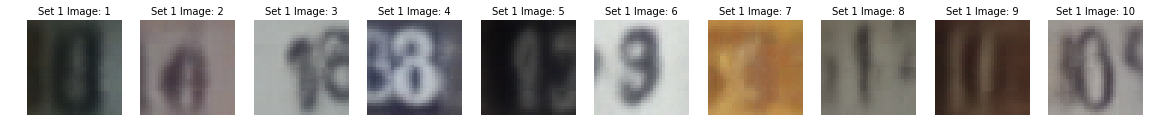

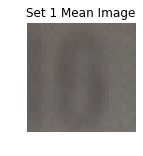

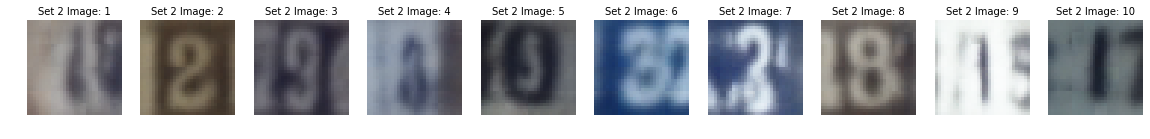

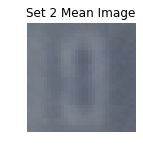

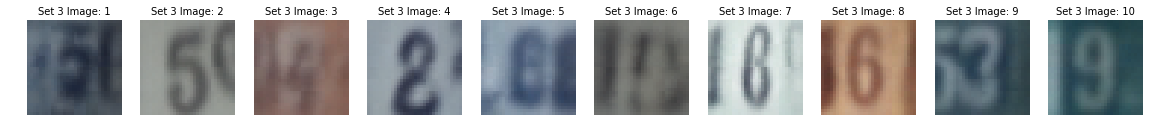

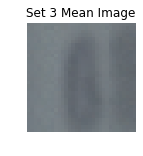

In [83]:
n = 10
sets = 3


for st in range(sets):
    eps = np.random.normal(0, 1, size=(n, dim_representation))

    decoded_imgs = Decoder.predict(eps)
    
    f, ax = plt.subplots(1,n, figsize=(20,4))
    for i in range(n):
        # Generated Image
        ax[i].imshow(decoded_imgs[i])
        ax[i].set_title('Set %d Image: %d' % (st+1, i+1), size=10)
        ax[i].axis('Off')
    
    mean_vec = np.mean(eps, axis=0)
    mean_img = Decoder.predict(np.array([mean_vec]))
    
    _, ax = plt.subplots(1,1, figsize=(2,2))
    ax.imshow(mean_img[0])
    ax.set_title('Set %d Mean Image' % (st+1))
    ax.axis('off')
    
    plt.show()
    
    print('\n')

### TASK 5

Finally, generate two random data points, their corresponding images. Then
* add 
* subtract 
* take the mean 

of both data points vectors and run each of these through the model and plot images. 

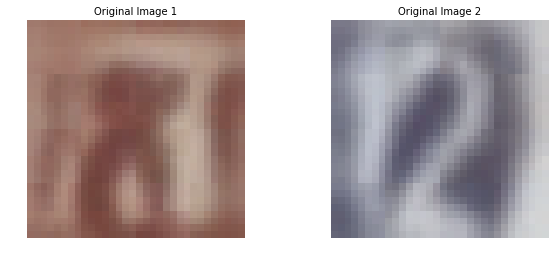

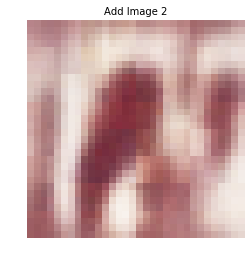

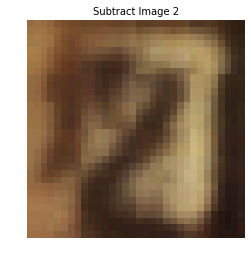

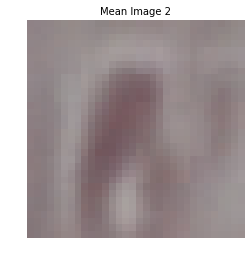

In [89]:
n = 2

# Random Samples
eps = np.random.normal(0, 1, size=(n, dim_representation))
decoded_imgs = Decoder.predict(eps)

f, ax = plt.subplots(1, 2, figsize=(10,4))
for i in range(n):
    # Generated Image
    ax[i].imshow(decoded_imgs[i])
    ax[i].set_title('Original Image '+ str(i+1), size=10)
    ax[i].axis('Off')
      
plt.show()

# Add
add_eps = eps[0] + eps[1]
add_decoded_imgs = Decoder.predict(np.array([add_eps]))

plt.imshow(add_decoded_imgs[0])
plt.title('Add Image '+ str(i+1), size=10)
plt.axis('Off')
      
plt.show()

# Subtract
sub_eps = eps[0] - eps[1]
sub_decoded_imgs = Decoder.predict(np.array([sub_eps]))

plt.imshow(sub_decoded_imgs[0])
plt.title('Subtract Image '+ str(i+1), size=10)
plt.axis('Off')
      
plt.show()

# Mean
mean_eps = np.mean(eps, axis=0)
mean_decoded_imgs = Decoder.predict(np.array([mean_eps]))

plt.imshow(mean_decoded_imgs[0])
plt.title('Mean Image '+ str(i+1), size=10)
plt.axis('Off')
      
plt.show()

__QUESTION__ - What similarities do you see in the resulting images for each of the three operations when compared to the original images.

__ANSWER__ - Add seems like try to have both the features of images.
Subtract is blur->Not readable.
Mean is also not readable.
